## Introducing Node2Vec

Node2Vec was introduced in 2016 by **Grover and Leskovec** from **Stanford University** [1].  
It keeps the same two main components from **DeepWalk**: *random walks* and *Word2Vec*.  
The difference is that instead of obtaining sequences of nodes with a **uniform distribution**, the random walks are **carefully biased** in Node2Vec.

We will see why these **biased random walks** perform better and how to implement them in the two following sections:

- **Defining a neighborhood**
- **Introducing biases in random walks**



### Defining a neighborhood

How do you define the neighborhood of a node?  
The key concept introduced in **Node2Vec** is the **flexible notion of a neighborhood**.  
Intuitively, we think of it as something close to the initial node,  
but what does “close” mean in the context of a graph?

Let’s take the following graph as an example:


<p align="center">
  <img src="images/1.jpg" width="400">
</p>


We want to explore three nodes in the neighborhood of node **A**. This exploration process is also called  
a **sampling strategy**:

- A possible solution would be to consider the three closest nodes in terms of connections.  
  In this case, the neighborhood of **A**, noted **N(A)**, would be:  
  **N(A) = {B, C, D}**

- Another possible sampling strategy consists of selecting nodes that are not adjacent to previous nodes first.  
  In our example, the neighborhood of **A** would be:  
  **N(A) = {D, E, F}**

In other words, we want to implement a **Breadth-First Search (BFS)** in the first case and a  
**Depth-First Search (DFS)** in the second one.  




What is important to notice here is that these sampling strategies have **opposite behaviors**:  
- **BFS** focuses on the local network around a node  
- while **DFS** establishes a more macro view of the graph.

Considering our intuitive definition of a neighborhood, it is tempting to simply discard **DFS**.  
However, the authors of **Node2Vec** argue that this would be a **mistake**:  
> Each approach captures a different but valuable representation of the network.


### Introducing biases in random walks

As a reminder, random walks are sequences of nodes that are randomly selected in a graph.  
They have a starting point, which can also be random, and a predefined length.  
Nodes that often appear together in these walks are like words that appear together in sentences:  
under the homophily hypothesis, they share a similar meaning, hence a similar representation.

---

### Improving Embeddings with Biased Random Walks in Node2Vec

In **Node2Vec**, our goal is to bias the randomness of these walks to either one of the following:

- Promoting nodes that are not connected to the previous one (similar to DFS)
- Promoting nodes that are close to the previous one (similar to BFS)

<p align="center">
  <img src="images/2.jpg" width="400">
</p>

 The current node is called **j**, the previous node is **i**, and the future node is **k**.  
We note **π<sub>jk</sub>**, the unnormalized transition probability from node **j** to node **k**.  
This probability can be decomposed as:

$$
\pi_{jk} = \alpha(i, k) \cdot \omega_{jk}
$$

where **α(i, k)** is the *search bias* between nodes **i** and **k**, and **ω<sub>jk</sub>** is the weight of the edge from **j** to **k**.

In **DeepWalk**, we have:

$$
\alpha(a, b) = 1
$$

for any pair of nodes **a** and **b**.  

In **Node2Vec**, the value of **α(a, b)** is defined based on the distance between the nodes and two additional parameters:  
- **p**, the return parameter  
- **q**, the in-out parameter  

Their role is to approximate **DFS** and **BFS**, respectively.


In **DeepWalk**, we have **α(a, b) = 1** for any pair of nodes **a** and **b**.  
In **Node2Vec**, the value of **α(a, b)** is defined based on the distance between the nodes and two additional parameters:  
- **p**, the return parameter, and  
- **q**, the in-out parameter.

Their role is to approximate **DFS** and **BFS**, respectively.



### Definition of α(a, b):

$$
\alpha(a, b) = 
\begin{cases}
\frac{1}{p} & \text{if } d_{ab} = 0 \\\\
1           & \text{if } d_{ab} = 1 \\\\
\frac{1}{q} & \text{if } d_{ab} = 2
\end{cases}
$$

Here, **d<sub>ab</sub>** is the shortest path distance between nodes **a** and **b**.



We can update the unnormalized transition probability from the previous graph as follows:

<p align="center">
  <img src="images/3.jpg" width="400">
</p>

- Transition back to **i**: weight = **1/p**  
- Transition to **k₁**: weight = **1**  
- Transition to **k₂**: weight = **1/q**


> When we say that $d_{ab} = 0$, it means that the node at time step $n+1$ is the same as the node at time step $n-1$.


### 🔍 Understanding the Meaning of These Probabilities

Let’s break down what each probability means:

- ✅ **The walk starts from node `i` and now arrives at node `j`.**  
  The probability of going back to the previous node `i` is controlled by the parameter **`p`**.  
  The **higher** the value of `p`, the **less likely** the walk is to go back — instead, it prefers exploring new nodes.  
  This makes the walk behave more like a **Depth-First Search (DFS)**.

- ✅ **The unnormalized probability of going to node `k₁` is 1**  
  because `k₁` is in the **immediate neighborhood** of the previous node `i`.  
  There’s no penalty or boost applied here — it’s treated as a neutral move.

- ✅ **The probability of going to node `k₂` is controlled by parameter `q`.**  
  The **higher** the value of `q`, the **less likely** the walk will explore distant nodes.  
  Instead, it prefers staying **close** to the previous node — just like in a **Breadth-First Search (BFS)**.



### 💡 Summary:

- Use **high `p`** to discourage returning to previous nodes (promotes DFS-style exploration).
- Use **high `q`** to discourage walking to distant nodes (promotes BFS-style exploration).

---

### 🔧 Next Step:

The best way to understand this behavior is to **implement** the algorithm and **experiment** with the values of `p` and `q`.

Let’s do this step by step on following graph:


In [28]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

/home/mohammadjavad/anaconda3/envs/py312/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


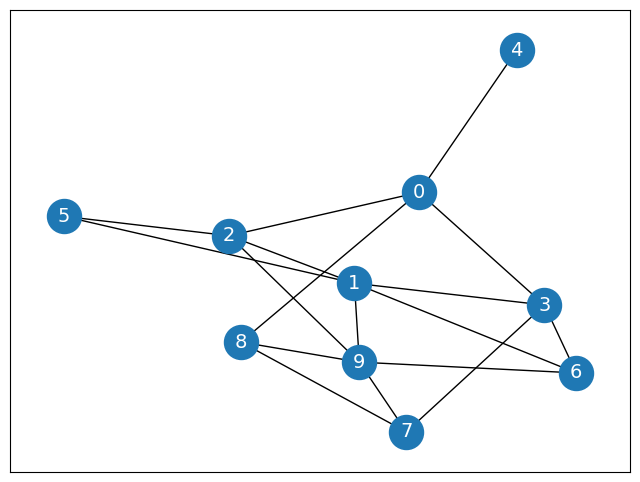

In [29]:
G = nx.erdos_renyi_graph(10, 0.3, seed=42, directed=False)

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(8, 6))
nx.draw_networkx(G,
                 pos=pos,
                 node_size=600,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'                
                 )

First, we want to create a function that will randomly select the next node in a graph based on the
previous node, the current node, and the two parameters and .

In [30]:
import random
random.seed(42)
np.random.seed(42)

In [31]:
def next_node(graph, previous, current, p, q):
    alphas = []

    neighbors = list(graph.neighbors(current))
    for neighbor in neighbors:
        if neighbor == previous:
            alpha = 1 / p
        elif graph.has_edge(previous, neighbor):
            alpha = 1
        else:
            alpha = 1 / q
        alphas.append(alpha)

    probs = [alpha / sum(alphas) for alpha in alphas]  # Normalize the alpha values to create transition probabilities

    next = np.random.choice(neighbors, size=1, p=probs)[0]
    return next

In [32]:
def random_walk(graph, start, length, p, q):
    w = [start]
    previous = None
    current = start

    for i in range(length):
        next = next_node(graph=graph, previous=previous, current=current, p=p, q=q)
        w.append(next)
        previous = w[i]
        current = w[-1]
    
    return w

In [33]:
random_walk(graph=G, start=1, length=10, p=1, q=1)

[1, 3, 7, 9, 6, 1, 2, 0, 8, 7, 9]

In [34]:
random_walk(graph=G, start=1, length=10, p=1000, q=0.5)

[1, 2, 9, 8, 0, 2, 1, 3, 6, 9, 2]

In [35]:
random_walk(graph=G, start=1, length=10, p=0.5, q=1000)

[1, 6, 1, 6, 1, 6, 9, 1, 9, 2, 1]

___

___

___

# Node2Vec

**Goal.** Learn node embeddings for Zachary’s Karate Club graph and use them to classify each node into two groups (“Mr. Hi” vs “Officer”) with a simple ML model (Random Forest).

## What this notebook does
1. **Build the graph** (`networkx.karate_club_graph`).
2. **Generate biased random walks** (Node2Vec):
   - `p` (return parameter): high → unlikely to go back; low → more backtracking.
   - `q` (in–out parameter):  
     - `q > 1` → BFS-like (stay local),  
     - `q < 1` → DFS-like (go deeper).
   - **DeepWalk** is the special case `p = 1`, `q = 1`.
3. **Train Word2Vec** on the walks to get one embedding vector per node.
4. **Build feature matrix** `X` by stacking node vectors in a fixed node order.
5. **Train & evaluate** a classifier (RandomForest) on `X` to predict the node labels.
6. **Report accuracy** and let you tune hyperparameters.

## Key hyperparameters
- `num_walks` (walks per node), `walk_length`, Word2Vec `window`, `embedding_size` (`size` in gensim 3.8.0), and classifier settings.
- Try several `(p, q)` pairs to see BFS/DFS bias effects on performance.

## Dependencies
- `networkx`, `gensim`, `scikit-learn`, `numpy`.
- This notebook uses **gensim==3.8.0** for compatibility (`size` argument).  
  If you use gensim ≥ 4, replace `size` with `vector_size`.

## Reproducibility
- We set random seeds where possible; results can still vary slightly due to multithreading and stochastic training.

**Output.** Trained embeddings for each node and a baseline classification accuracy.  
**Tip.** Start with `p = 1, q = 1` (DeepWalk), then sweep `q` (e.g., `0.5, 1, 2`) to observe local vs. global exploration effects.


In [8]:
import gensim
import networkx as nx
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [43]:
# Load Zachary’s Karate Club
G = nx.karate_club_graph()

/home/mohammadjavad/anaconda3/envs/py312/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


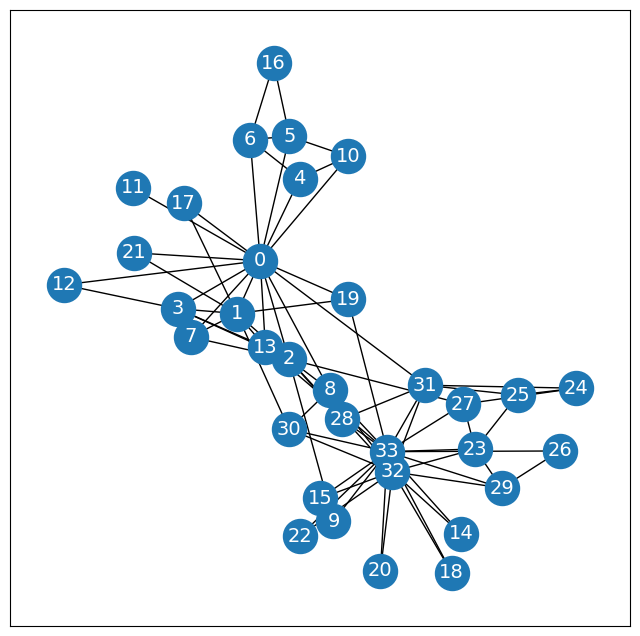

In [44]:
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(8, 8))
nx.draw_networkx(G=G,
                 pos=pos,
                 node_size=600,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'                  
                 )

In [13]:
print(f'Nodes of Graph are: {G.nodes()}')
print(f'Number of nodes is: {len(G.nodes())}')

Nodes of Graph are: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Number of nodes is: 34


In [62]:
# assign 1 if label= 'officer' and 0 if label='Mr. Hi 
labels = [0 if G.nodes[node]['club'] == 'Mr. Hi' else 1 for node in G.nodes()]

In [78]:
walks = []

for node in G.nodes():
    for _ in range(80):
        walks.append(random_walk(graph=G, start=node, length=10, p=7, q=7))

In [79]:
node2vec = Word2Vec(walks,
                    hs=1,
                    sg=1,
                    vector_size=100,
                    window=10,
                    workers=2,
                    min_count=1,
                    seed=42
                    )

In [80]:
node2vec.train(
    walks,                               # Training data: list of random walks (node sequences)
    total_examples=node2vec.corpus_count, # Total number of sentences (random walks) → usually the model's corpus_count
    epochs=30,                           # Number of times the entire dataset is iterated over (epochs)
    report_delay=1                       # Time interval (in seconds) for reporting training progress
)

(184038, 897600)

In [81]:
train_mask = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]
test_mask = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]

labels = np.array(labels)

X_train = node2vec.wv[train_mask]
y_train = labels[train_mask]

X_test = node2vec.wv[test_mask]
y_test = labels[test_mask]

print(f'Shape of X train: {X_train.shape}')
print(f'Shape 0f X test: {X_test.shape}')
print(f'Shape of y train: {y_train.shape}')
print(f'Shape of y test: {y_test.shape}')

Shape of X train: (22, 100)
Shape 0f X test: (12, 100)
Shape of y train: (22,)
Shape of y test: (12,)


In [82]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X = X_train, y=y_train)

RandomForestClassifier(random_state=42)

In [83]:
y_pred = clf.predict(X=X_test)

In [84]:
acc = accuracy_score(y_pred, y_test)
print(f'Node2Vec accuracy = {acc*100:.2f}%')

Node2Vec accuracy = 91.67%


___

___

___

In [91]:
from zipfile import ZipFile
import pandas as pd

In [87]:
import os
print(os.getcwd())


/mnt/e/GNNs/06_Graph_Embeding_Node2Vec


In [90]:
with ZipFile('ml-100k.zip', 'r') as zfile:
    zfile.extractall()

In [ ]:
ratings = pd.read_csv('ml-100k/u.data',
                    sep='\t', 
                    names=['user_id', 'movie_id', 'rating', 'unix_timestamp'])


In [95]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [96]:
ratings.tail()

,user_id,movie_id,rating,unix_timestamp
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156
99999,12,203,3,879959583


In [97]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   user_id         100000 non-null  int64
 1   movie_id        100000 non-null  int64
 2   rating          100000 non-null  int64
 3   unix_timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [99]:
movies = pd.read_csv('ml-100k/u.item', 
                     sep='|',
                     usecols=range(2), 
                     names=['movie_id', 'title'],
                     encoding='latin-1')

In [100]:
movies.head()

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [112]:
movies.tail()

,movie_id,title
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)
1681,1682,Scream of Stone (Schrei aus Stein) (1991)


In [113]:
movies

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


In [114]:
ratings

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [115]:
ratings['rating'].unique()

array([3, 1, 2, 4, 5])

In [116]:
ratings = ratings[ratings['rating'] >= 4]

In [117]:
ratings

,user_id,movie_id,rating,unix_timestamp
5,298,474,4,884182806
7,253,465,5,891628467
11,286,1014,5,879781125
12,200,222,5,876042340
16,122,387,5,879270459
...,...,...,...,...
99988,421,498,4,892241344
99989,495,1091,4,888637503
99990,806,421,4,882388897
99991,676,538,4,892685437
